<a href="https://colab.research.google.com/github/MAbuTalha/Neural-Machine-Translation-NMT-/blob/main/Machine_Translation_Word_level_model_(English_to_Urdu).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Sequence-to-Sequence learning in Keras**

**What is sequence-to-sequence learning?**

Sequence-to-sequence learning (Seq2Seq) is about training models to convert sequences from one domain (e.g. sentences in English) to sequences in another domain (e.g. the same sentences translated to Urdu or German).

This can be used for machine translation or for free-from question answering (generating a natural language answer given a natural language question) -- in general, it is applicable any time you need to generate text.

There are multiple ways to handle this task, either using RNNs or using 1D convnets. Here I will focus on RNNs.

***The trivial case: when input and output sequences have the same length***

When both input sequences and output sequences have the same length, you can implement such models simply with a Keras LSTM or GRU layer (or stack thereof). This is the case in this example script that shows how to teach a RNN to learn to add numbers, encoded as character strings:

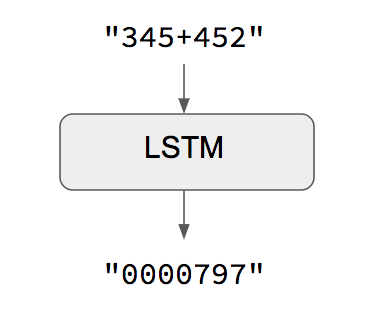

**The general case: canonical sequence-to-sequence**

In the general case, input sequences and output sequences have different lengths (e.g. machine translation) and the entire input sequence is required in order to start predicting the target. This requires a more advanced setup, which is what people commonly refer to when mentioning "sequence to sequence models" with no further context. Here's how it works:

-> A RNN layer (or stack thereof) acts as "encoder": it processes the input sequence and returns its own internal state. Note that we discard the outputs of the encoder RNN, only recovering the state. This state will serve as the "context", or "conditioning", of the decoder in the next step.

-> Another RNN layer (or stack thereof) acts as "decoder": it is trained to predict the next characters of the target sequence, given previous characters of the target sequence. Specifically, it is trained to turn the target sequences into the same sequences but offset by one timestep in the future, a training process called "teacher forcing" in this context. Importantly, the encoder uses as initial state the state vectors from the encoder, which is how the decoder obtains information about what it is supposed to generate. Effectively, the decoder learns to generate targets[t+1...] given targets[...t], conditioned on the input sequence.

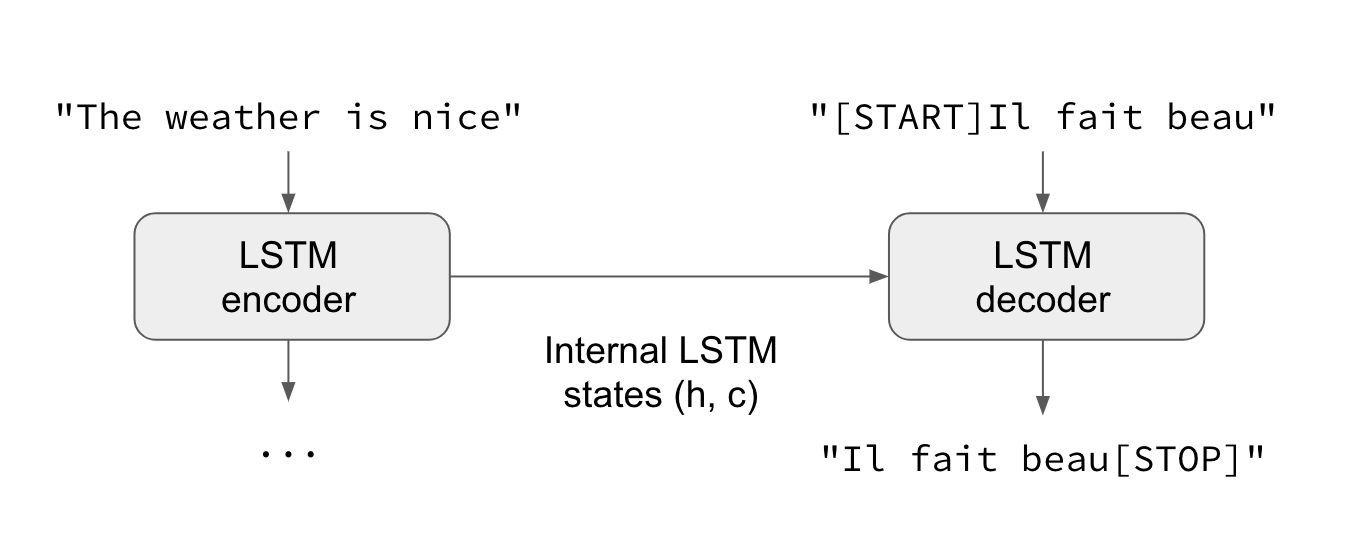




In inference mode, i.e. when we want to decode unknown input sequences, we go through a slightly different process:

1) Encode the input sequence into state vectors.

2) Start with a target sequence of size 1 (just the start-of-sequence character).

3) Feed the state vectors and 1-char target sequence to the decoder to produce predictions for the next character.

4) Sample the next character using these predictions (we simply use argmax).

5) Append the sampled character to the target sequence

6) Repeat until we generate the end-of-sequence character or we hit the character limit.

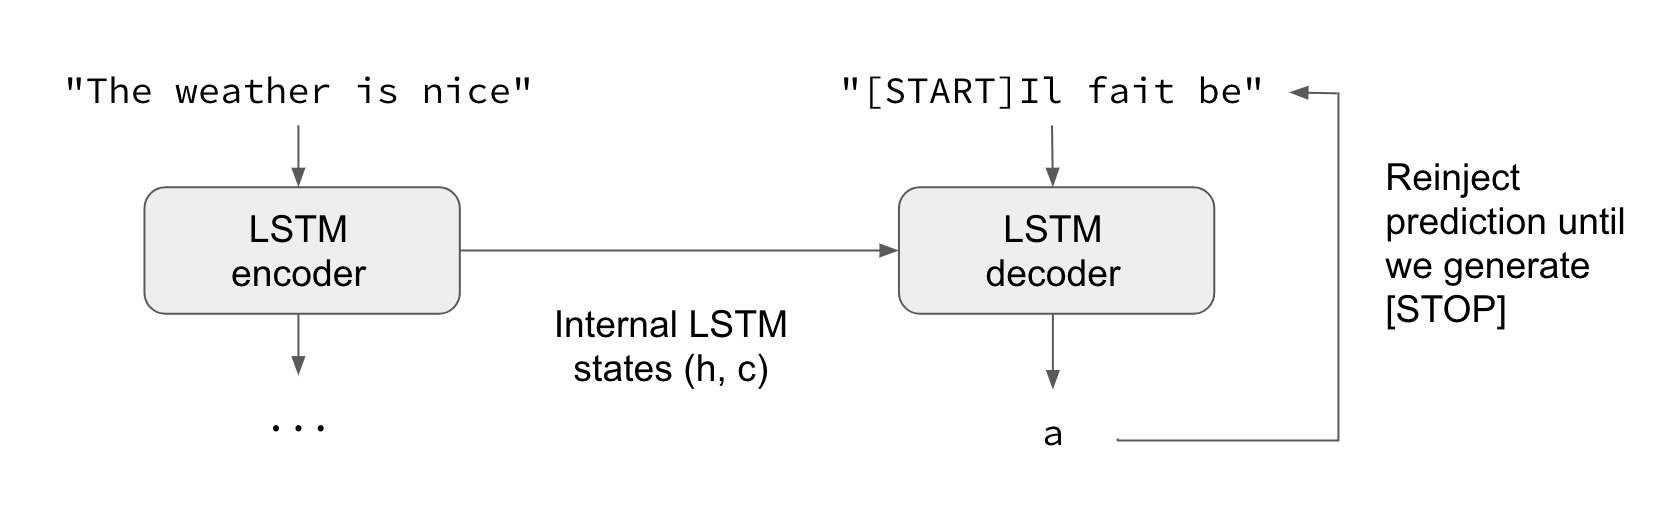

The same process can also be used to train a Seq2Seq network without "teacher forcing", i.e. by reinjecting the decoder's predictions into the decoder.

## A Keras example
Let's illustrate these ideas with actual code.

For our example implementation, we will use a dataset of pairs of English sentences and their Urdu translation, which you can download from [manythings.org/anki](http://www.manythings.org/anki/). The file to download is called urdu-eng.zip. We will implement a word-level model sequence-to-sequence model.


**Import Required Libararies**

In [124]:
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model

**Read data from file**

In [125]:
lines=pd.read_table('urdu.txt', names=['eng', 'urdu'],index_col=False,encoding = 'utf-16')

In [126]:
lines.shape

(1146, 2)

**Clean the source and target sentences**


In [127]:
# Lowercase all characters
lines.eng=lines.eng.apply(lambda x: x.lower())
lines.urdu=lines.urdu.apply(lambda x: x.lower())

# Remove quotes
lines.eng=lines.eng.apply(lambda x: re.sub("'", '', x))
lines.urdu=lines.urdu.apply(lambda x: re.sub("'", '', x))

exclude = set(string.punctuation) # Set of all special characters

# Remove all the special characters
lines.eng=lines.eng.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines.urdu=lines.urdu.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)
lines.eng=lines.eng.apply(lambda x: x.translate(remove_digits))

# Remove extra spaces
lines.eng=lines.eng.apply(lambda x: x.strip())
lines.urdu=lines.urdu.apply(lambda x: x.strip())
lines.eng=lines.eng.apply(lambda x: re.sub(" +", " ", x))
lines.urdu=lines.urdu.apply(lambda x: re.sub(" +", " ", x))

# Add start and end tokens to target sequences
lines.urdu = lines.urdu.apply(lambda x : 'START_ '+ x + ' _END')

lines.sample(10)

,eng,urdu
506,thats what i want to know,START_ یہ ہی تو میں جاننا چاہتا ہوں۔ _END
1131,on my way home from school yesterday i was cau...,START_ کل سکول سے واپس آتے ہوئے میں بارش کی لپ...
694,im a childhood friend of toms,START_ میں ٹام کا بچپن کا دوست ہوں۔ _END
1121,his mother said that he had been sick in bed f...,START_ اس کی امی نے بتایا ہے کہ وہ پانچ ہفتوں ...
1088,tom fell in love with mary the first time he s...,START_ ٹام نے جب پہلی دفعہ مریم کو دیکھا تو وہ...
532,i lent my friend some money,START_ میں نے اپنے دوست کو کچھ پیسے ادھار دیے ...
443,what are you going to do,START_ آپ کیا کریں گے؟ _END
398,he caught me by the hand,START_ اس نے مجھے میرے ہاتھ سے پکڑ لیا۔ _END
411,i owe ten dollars to her,START_ میں نے اس کے دس ڈالر دینے ہے۔ _END
583,prices seem to be going down,START_ لگتا ہے کہ قیمتیں گر رہی ہیں۔ _END


**Create a set of unique words both for source and target language from the dataset**

In [128]:

# Vocabulary of English
all_eng_words=set()
for eng in lines.eng:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)

# Vocabulary of Urdu 
all_urdu_words=set()
for urdu in lines.urdu:
    for word in urdu.split():
        if word not in all_urdu_words:
            all_urdu_words.add(word)



**Find the maximum length of the source and target sentences in the dataset**



In [129]:
# Max Length of source sequence
lenght_list=[]
for l in lines.eng:
    lenght_list.append(len(l.split(' ')))
max_length_src = np.max(lenght_list)
print('Max Source Length:',max_length_src)

# Max Length of target sequence
lenght_list=[]
for l in lines.urdu:
    lenght_list.append(len(l.split(' ')))
max_length_tar = np.max(lenght_list)
print('Max Target Lenght:',max_length_tar)


Max Source Length: 18
Max Target Lenght: 23


In [130]:
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_urdu_words))
num_encoder_tokens = len(all_eng_words)+1
num_decoder_tokens = len(all_urdu_words)+1
num_encoder_tokens, num_decoder_tokens

(1311, 1708)

In [131]:
num_decoder_tokens += 1 # For zero padding
num_decoder_tokens

1709

**Create a word to index dictionary and an index to word dictionary for all unique source and target words in the dataset.**

Size of the word to vector will be based on the length of the source and target vocabulary

**Shuffle the data**

Shuffling helps with

*   Reducing variance
*   Ensures models remain generic and overfit less
*   Batches between epochs do not look alike
*   Makes model more robust





In [132]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

lines = shuffle(lines)
lines.head(10)

,eng,urdu
659,please tell everyone im sorry,START_ برائے مہربانی سب کو بتادو کہ میں شرمندہ...
797,the house fell down one week later,START_ وہ گھر ایک ہفتہ بعد ہی زمین بوس ہو گیا۔...
158,you got hit hard,START_ تمہیں بڑی زور کی لگی ہے۔ _END
496,im going to reconsider it,START_ میں اس پر دوبارہ نظر ثانی کرو گا۔ _END
690,i dont know if i have the time,START_ میں نہیں جانتا اگر میرے پاس وقت ہوا تو ...
1039,ten years have passed since he went to america,START_ دس سال ہو گئے ہیں اسے امریکہ گئے ہوئے۔ ...
242,its a real bargain,START_ یہ اچھا سودا ہے۔ _END
913,those books are always in great demand,START_ ان کتابوں کی ہمیشہ بہت مانگ رہتی ہے۔ _END
172,he won everything,START_ اس نے سب کچھ جیت لیا۔ _END
933,there is a car in front of the building,START_ عمارت کے سامنے ایک گاڑی کھڑی ہے۔ _END


**Creating training and test dataset**


In [133]:
# Train - Test Split
X, y = lines.eng, lines.urdu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
X_train.shape, X_test.shape


((1031,), (115,))

In [134]:
#Save the train and test dataframes for reproducing the results later, as they are shuffled.

X_train.to_pickle('X_train.pkl')
X_test.to_pickle('X_test.pkl')


**Create data for training the encoder-decoder model.**

We will **fit()** method

We create the underlying function **generate_batch()** for generating data in batches

The **fit()** will accept a batch of data from the underlying function, **generate_batch()**

To train a sequence to sequence model, we need to create one-hot encoded data for

**encoder inputs:** The 2D array will be of shape (batch_size, max source sentence length). For a batch_size of 64 and a max source sentence length of 18, the shape of encoder_input will be (64,18)

decoder inputs: The 2D array will be of shape (batch_size, max target sentence length). For a batch_size of 64 and a max target sentence length of 23, the shape of decoder inputs will be (64,23)
decoder outputs: The 3D array will be of shape (batch_size, max target sentence length, number of unique words in target sentences). For a batch_size of 64 and a max target sentence length of 23, the shape of decoder output will be (64,23, 1709).
Number of unique words in the target_sentence is 1708 which we zero pad, and hence the third parameter in decoder output is 1709

In [135]:
def generate_batch(X = X_train, y = y_train, batch_size = 64):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

**Build the sequence to sequence model**

**Setup basic parameters**

We set the necessary parameters like


*   number of training samples
*   number of validation samples
*   batch_size used for creating the training data
*   Epochs to train on
*   The latent dimension of the encoding space












In [136]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 64
epochs = 100
latent_dim = 256
print(train_samples//batch_size)
print(val_samples//batch_size)

16
1


**Building the Model**

Build the encoder and decoder using LSTM. The encoder will encode the input sentences of the source language. Hidden state and the cell state of the encoder will be passed as input to the decoder along with actual target sequences.

**Build the Encoder**

The encoder will encode the input sequence. We pass the input through the input layer. The first hidden layer will be the embedding layer. Embeddings translate large sparse vectors into a dense lower-dimensional space preserving the semantic relationships.

Pass three parameters to **Embedding(); the first parameter is the size of the vocabulary; the second parameter is the dimension of the dense Embedding.** We set **mask_zero** as True as this implies that the input value of 0 is a special “padding” value that should be masked out.

**Create the LSTM layer and only set return_state to True** as we want to retain the hidden state and cell state of the encoder. We discard the encoder_output and preserve the hidden state and cell state of the LSTM to be passed to the decoder

In [137]:
# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

**Build the Decoder**

We create an input layer for the decoder_inputs; Embedding is again the first hidden layer in the decoder.

The LSTM layer will return output sequences as well as the internal states. The internal states will be used only during the inference phase and will not be used during the training phase.

LSTM in the decoder takes input from the embedding layer and the encoder states. We apply a softmax activation to the Dense layer and then finally generate the decoder outputs

In [138]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

**Define the model**

The sequence to sequence model takes encoder and decoder inputs to output decoder outputs

In [139]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

**Train the model**

To train the model, we first compile the model and then fit the data to the model

We compile the model using “rmsprop” optimizer; use categorical_crossentropy as we use categorical labels which is one-hot encoded vectors

In [140]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

Fit the model using fit(). we had already created the underlying function for generating the data, generate_batch() for generating the training and the test dataset.

steps_per_epoch is computed by dividing the total number of training samples by the batch size. When we reach the step count, we start with a new epoch

In [141]:
model.fit(generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)

Epoch 1/100
16/16 [==============================] - 18s 582ms/step - loss: 2.2880 - acc: 0.1270 - val_loss: 1.8957 - val_acc: 0.1606
Epoch 2/100
16/16 [==============================] - 6s 393ms/step - loss: 1.8787 - acc: 0.1488 - val_loss: 1.8726 - val_acc: 0.1626
Epoch 3/100
16/16 [==============================] - 6s 398ms/step - loss: 1.8337 - acc: 0.1520 - val_loss: 1.8532 - val_acc: 0.1524
Epoch 4/100
16/16 [==============================] - 6s 401ms/step - loss: 1.7776 - acc: 0.1557 - val_loss: 1.8302 - val_acc: 0.1707
Epoch 5/100
16/16 [==============================] - 6s 406ms/step - loss: 1.7351 - acc: 0.1622 - val_loss: 1.8204 - val_acc: 0.1748
Epoch 6/100
16/16 [==============================] - 7s 469ms/step - loss: 1.7011 - acc: 0.1691 - val_loss: 1.8184 - val_acc: 0.1789
Epoch 7/100
16/16 [==============================] - 6s 402ms/step - loss: 1.6597 - acc: 0.1774 - val_loss: 1.8209 - val_acc: 0.2053
Epoch 8/100
16/16 [==============================] - 6s 390ms/step -

In [142]:
#Always remember to save the weights

model.save_weights('etu_weights.h5')

In [143]:
#Load the weights, if you close the application

model.load_weights('etu_weights.h5')

**Make inferences from the model**

During inference, we want to decode unknown input sequences to predict the output.

**Steps for inference**


*   Encode the input sequences into hidden state and cell state of the LSTM
*   The decoder will predict one sequence at a time. The first input to the decoder will be hidden state and cell state of the encoder and the START_ tag
*   The output of the decoder will be fed as an input to the decoder for the next time step as shown in the diagram below

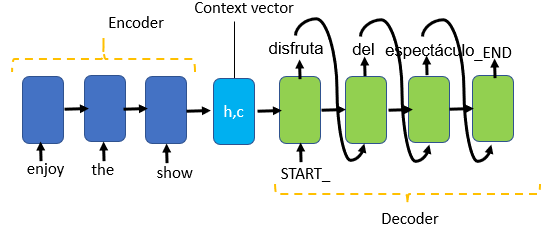

*   At each time step, decoder outputs one-hot encoded vector to which we apply np.argmax and convert the vector to word from the dictionary that stores index to word
*   Keep appending the target words generated at each time step
*   Repeat the steps till we hit the _END tag or the word limit






In [144]:
#Inference Setup

# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)


In [145]:
#Decode sample sequeces

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence



**Evaluation on Train Dataset**

In [146]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1

In [147]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Urdu Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Urdu Translation:', decoded_sentence[:-4])

Input English sentence: could you call a doctor please
Actual Urdu Translation:  کیا تم ڈاکٹر کو بلا سکتی ہو؟ 
Predicted Urdu Translation:  کیا آپ ڈاکٹر کو بلا سکتی ہے؟ 


In [148]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Urdu Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Urdu Translation:', decoded_sentence[:-4])

Input English sentence: i am older than your brother
Actual Urdu Translation:  میں تمہارے بھائی سے بڑی ہوں۔ 
Predicted Urdu Translation:  میں تمہارے بھائی سے بڑا ہوں۔ 


In [149]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Urdu Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Urdu Translation:', decoded_sentence[:-4])

Input English sentence: could you call a doctor please
Actual Urdu Translation:  کیا آپ ڈاکٹر کو بلا سکتے ہے؟ 
Predicted Urdu Translation:  کیا آپ ڈاکٹر کو بلا سکتی ہے؟ 


**Evaluation on Validation Dataset**

In [150]:
val_gen = generate_batch(X_test, y_test, batch_size = 1)
k=-1

In [152]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Urdu Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Urdu Translation:', decoded_sentence[:-4])

Input English sentence: poverty drove him to steal
Actual Urdu Translation:  غربت نے اسے چوری کرنے پر مجبور کیا۔ 
Predicted Urdu Translation:  اس نے اپنا منہ کی۔ 


In [153]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Urdu Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Urdu Translation:', decoded_sentence[:-4])

Input English sentence: hi
Actual Urdu Translation:  سلام۔ 
Predicted Urdu Translation:  صبح بخير۔ 


In [154]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Urdu Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Urdu Translation:', decoded_sentence[:-4])

Input English sentence: i know that youre rich
Actual Urdu Translation:  میں جانتا ہوں کہ تم امیر ہو۔ 
Predicted Urdu Translation:  مجھے پتا ہے کہ آپ امیر ہے۔ 
